In [18]:
import torch
import torchvision
from torch import nn

## Downloading PyTorch Modular Scripts

In [ ]:
import os
from pathlib import Path
import requests

# os.chdir("Z:/ML")

base_url = r"https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular"


files = [
    "data_setup.py",
    "engine.py",
    "model_builder.py",
    "predictions.py",
    "train.py",
    "utils.py"]

target_dir = Path("going_modular")

if target_dir.exists():
    print("Already exists!")
else:
    print("Couldn't find, downloading......")
    target_dir.mkdir(exist_ok=True)

    for file_name in files:
        file_url = f"{base_url}/{file_name}"
        response = requests.get(file_url)
        response.raise_for_status()

        file_path = target_dir / file_name
        file_path.write_text(response.text)
        
    print("Downloaded!")

Already exists!


## `download_data()` — Download and Extract Dataset

In [ ]:
from pathlib import Path
import os
import requests
import zipfile

# os.chdir("Z:/ML")


def download_data(source: str,
                  destination: str,
                  remove_source: bool=True):
    
    data_path = Path("data/")
    image_path = data_path / destination # a subfolder name

    if image_path.is_dir():
        print(f"[INFO] {image_path} directory already exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # get our zipfile name
        target_file = Path(source).name 
        
        with open(data_path / target_file, "wb") as f:
            response = requests.get(source)
            response.raise_for_status()
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(response.content)
        
        with zipfile.ZipFile(data_path / target_file, 'r') as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)
        
        if remove_source:
            print(f"[INFO] Removing {target_file}...")
            os.remove(data_path / target_file)
    
    return image_path

In [21]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi_10_percent")
image_path

[INFO] data\pizza_steak_sushi_10_percent directory already exists, skipping download.


WindowsPath('data/pizza_steak_sushi_10_percent')

## Dataset Directory Setup

In [22]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_10_percent/train'),
 WindowsPath('data/pizza_steak_sushi_10_percent/test'))

## Vision Transformer (ViT-B/16) Setup 

In [23]:
import torchvision

weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model = torchvision.models.vit_b_16(weights=weights)

transform = weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## Data Loaders Setup for Vision Transformer


In [ ]:
from going_modular import data_setup

NUM_WORKERS = 0
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               num_workers=NUM_WORKERS,
                                                                               transform=transform,
                                                                               batch_size=BATCH_SIZE)

## Model Configuration for Transfer Learning


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for parameter in model.parameters():
    parameter.requires_grad = False

torch.manual_seed(42)

model.heads = nn.Linear(in_features=768,
                        out_features=len(class_names)).to(device)

## Model Architecture Summary


In [ ]:
try:
    from torchinfo import summary
except:
    %pip install torchinfo
    from torchinfo import summary
  
summary(model=model,
        input_size=(1, 3 , 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Model Training Configuration & Training Setup and Execution

In [28]:
from going_modular import engine

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

torch.manual_seed(42)
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


## Downloading Helper Functions to Plot Loss Curves

In [29]:
url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"

response = requests.get(url)
response.raise_for_status()

with open("helper_functions.py", 'wb') as f:
    f.write(response.content)

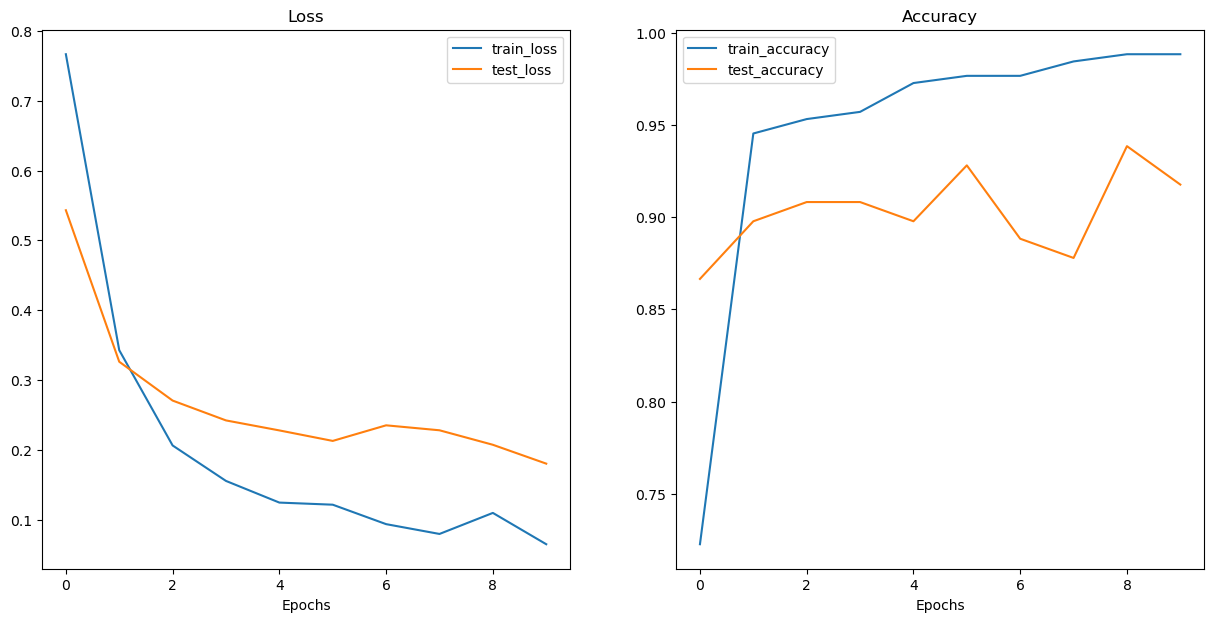

In [30]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## Saving Model Weights

In [ ]:
save_dir = Path("models")
save_dir.mkdir(exist_ok=True, parents=True)

save_path = save_dir / "vit_model.pth"

torch.save(model.state_dict(), save_path)

## Loading a Saved ViT Model

In [32]:
loaded_model = torchvision.models.vit_b_16(weights=None)

# Replace the classification head before loading weights to ensure key names match the saved state_dict

loaded_model.heads = nn.Linear(in_features=768, out_features=len(class_names))
loaded_model.load_state_dict(torch.load(save_path), strict=False)

loaded_model.heads

Linear(in_features=768, out_features=3, bias=True)

## Checking Saved Model File Size

In [42]:
loaded_model_size = Path(r"models/vit_model.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {loaded_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## Visualizing Model Predictions on Sample Test Images

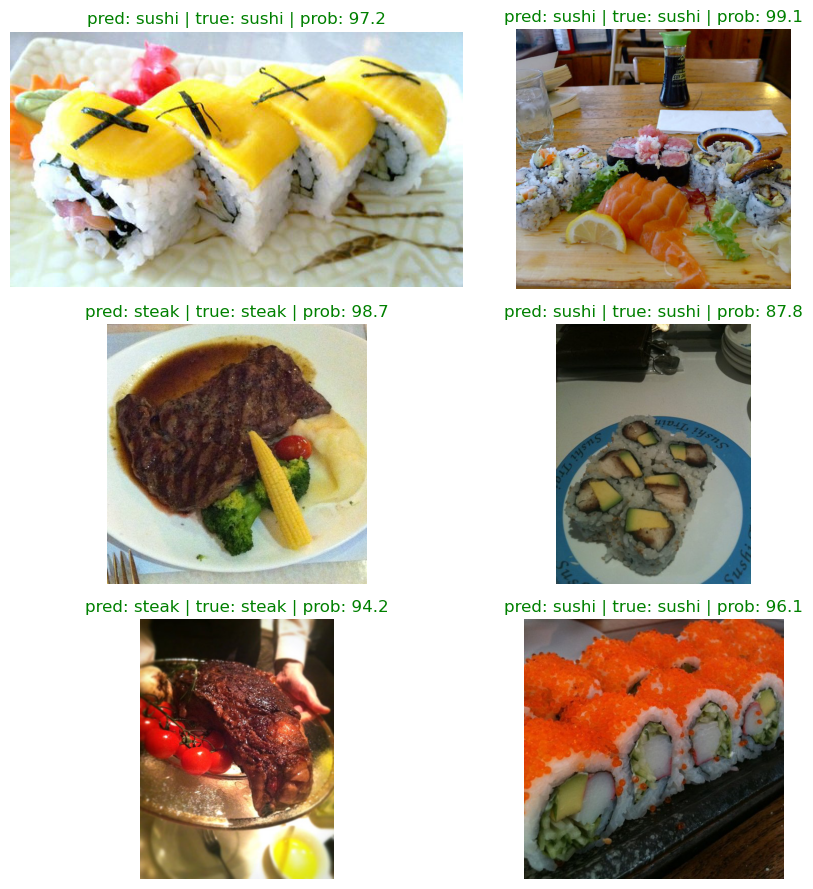

In [41]:
import matplotlib.pyplot as plt
from PIL import Image
import random


images_path_list = list(Path(test_dir).glob("*/*.jpg"))

fig = plt.figure(figsize=(9, 9))
sampled_images = random.sample(images_path_list, k=6)
rows, cols = 3, 2

loaded_model.to(device)
loaded_model.eval()

for i in range(6):
    img = Image.open(sampled_images[i])
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis(False)

    with torch.inference_mode():
        transformed_img = transform(img).unsqueeze(dim=0)
        pred = loaded_model(transformed_img.to(device))
    
    pred_probs = torch.softmax(pred, dim=1)
    pred_label = torch.argmax(pred_probs, dim=1).item()

    true_label = sampled_images[i].parent.name
    
    if class_names[pred_label] == true_label:
            plt.title(f"pred: {class_names[pred_label]} | true: {true_label} | prob: {pred_probs.max().item()*100:.1f}", color='green')
    else:
        plt.title(f"pred: {class_names[pred_label]} | true: {true_label} | prob: {pred_probs.max().item()*100:.1f}", color='red')

plt.tight_layout()
plt.show()


## Collecting Predictions and True Labels from the Test Set

In [35]:
y_preds = []
labels = []

loaded_model.eval()

with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        y_logits = loaded_model(X)
        y_pred = torch.argmax(y_logits, dim=1)

        y_preds.append(y_pred)
        labels.append(y)

y_preds_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(labels)

## Plotting a Confusion Matrix for Multiclass Classification

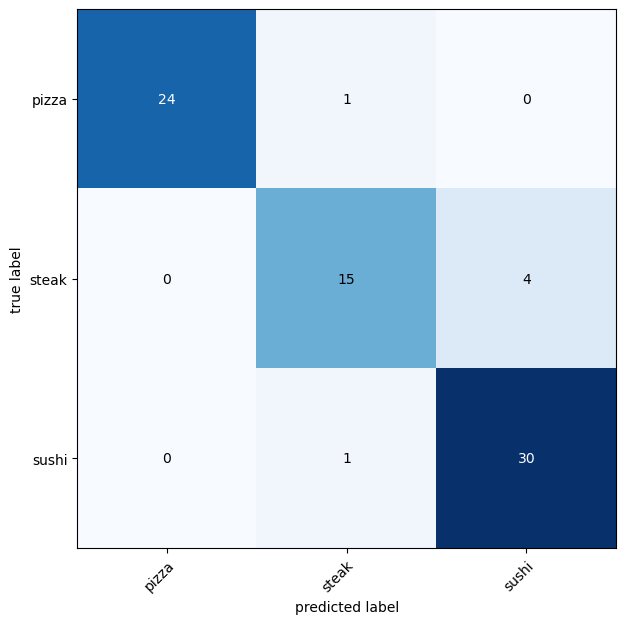

In [ ]:
try:
    from torchmetrics import ConfusionMatrix
except:
    %pip install torchmetrics
    from torchmetrics import ConfusionMatrix
  
try:
    from mlxtend.plotting import plot_confusion_matrix
except ImportError:
    %pip install mlxtend
    from mlxtend.plotting import plot_confusion_matrix


confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))

confmat_tensor = confmat(y_preds_tensor.cpu(), y_true_tensor.cpu())

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10, 7))